# Plot EKE for POP data

In [1]:
from netCDF4 import Dataset
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cmocean
import xarray as xr
from xgcm import Grid
from dask.diagnostics import ProgressBar
import filter
#from dask.distributed import Client

## Open POP 0.1 degree data

In [2]:
ds = xr.open_dataset('/glade/work/igrooms/current_data', decode_times=False)

### The only loaded time slice is a 5-day average

In [3]:
ds['time_bound'].values

array([[12370., 12375.]])

### Make ocean ("wet") mask for U points

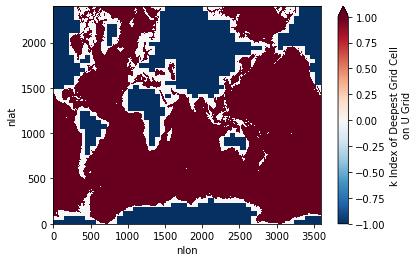

In [4]:
ds.KMU.plot(vmin=ds.KMU.min())

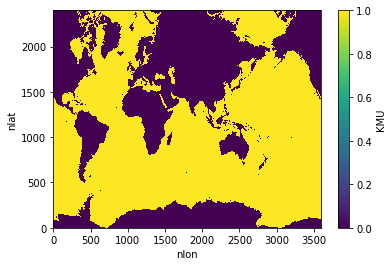

In [5]:
wetu_mask = xr.where(ds['KMU']>0,1,0)
wetu_mask.plot()

## Plot surface velocity

[Text(0.5, 1.0, 'surface velocity in y-direction')]

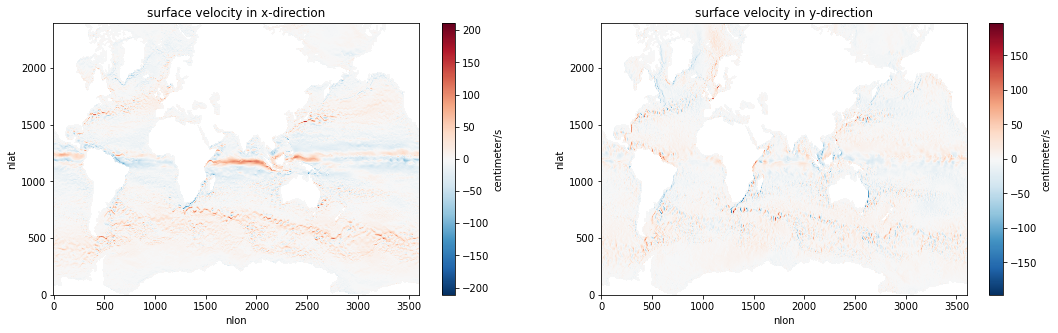

In [7]:
UVEL = ds['UVEL'].isel(z_t=0)
UVEL = xr.where(wetu_mask==1,UVEL,np.nan)
VVEL = ds['VVEL'].isel(z_t=0)
VVEL = xr.where(wetu_mask==1,VVEL,np.nan)

fig,axs = plt.subplots(1,2,figsize=(18,5))
UVEL.plot(ax=axs[0],cbar_kwargs={"label": ds.UVEL.units})
VVEL.plot(ax=axs[1],cbar_kwargs={"label": ds.VVEL.units})
axs[0].set(title='surface velocity in x-direction')
axs[1].set(title='surface velocity in y-direction')

## Before filtering, rotate velocities

UVEL and VVEL are NOT zonal and meridional velocities in the lat/lon sense. They are velocities with respect to the model grid, which is locally rotated by ANGLE radians with respect to lat/lon directions. So to convert to zonal & meridional velocities, we need to project UVEL and VVEL onto zonal & meridional directions. Here's how :
                                     
true_zonal_velocity = cos(ANGLE) * UVEL - sin(ANGLE) * VVEL  
true_merid_velocity = sin(ANGLE) * UVEL + cos(ANGLE) * VVEL 

In [8]:
zonVEL = np.cos(ds['ANGLE']) * UVEL - np.sin(ds['ANGLE']) * VVEL
merVEL = np.sin(ds['ANGLE']) * UVEL + np.cos(ds['ANGLE']) * VVEL
ds['zonVEL'] = zonVEL
ds['merVEL'] = merVEL

## Kinetic energy (of surface level)
$$
KE = u^2 + v^2
$$

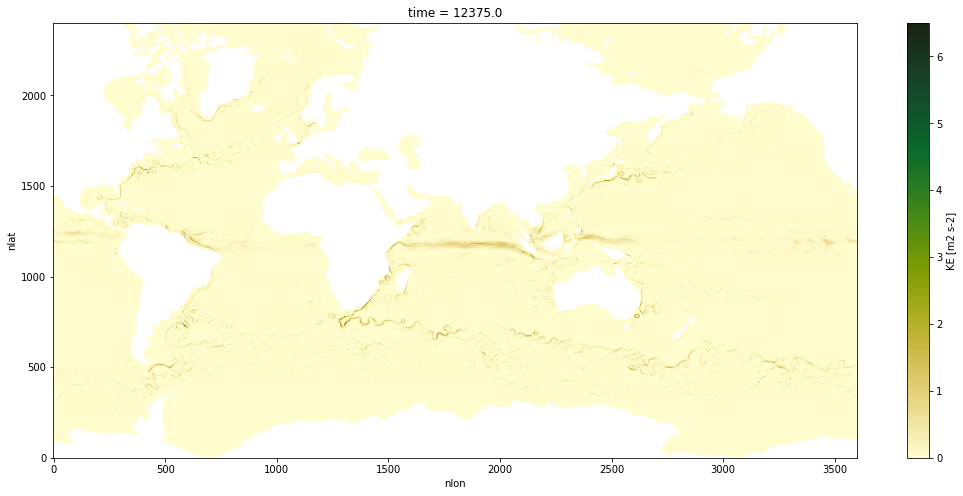

In [9]:
ds['KE'] = ds['zonVEL']**2 + ds['merVEL']**2

(0.0001*ds['KE']).plot(figsize=(18,8),cmap=cmocean.cm.speed, cbar_kwargs={"label": 'KE [m2 s-2]'})

# Define filters: 0.1 degree --> 1 degree

In [10]:
filter_fac = 10

### Gaussian

# Laplacian steps: 18; # Biharmonic steps: 1


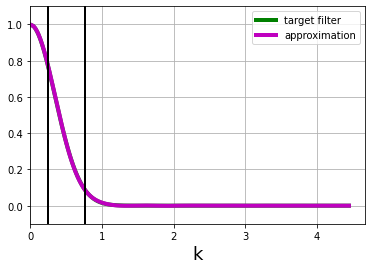

In [11]:
Lf_g = filter_fac/np.sqrt(6) 
N_g=20
NL_g, sL_g, NB_g, sB_g = filter.filterSpec(N_g, 1, Lf_g, 'Gaussian')
print('# Laplacian steps: ' + str(NL_g) + '; # Biharmonic steps: ' + str(NB_g))

### Taper

# Laplacian steps: 38; # Biharmonic steps: 1


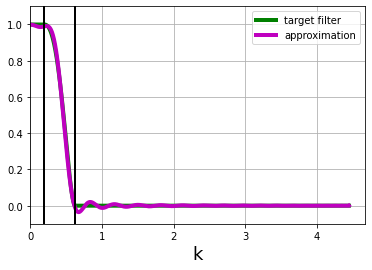

In [12]:
Lf_t = filter_fac/2
N_t=40
NL_t, sL_t, NB_t, sB_t = filter.filterSpec(N_t, 1, Lf_t, 'Taper')
print('# Laplacian steps: ' + str(NL_t) + '; # Biharmonic steps: ' + str(NB_t))

In [13]:
try:
    from cupy import get_array_module as _get_array_module
except ImportError:
    import numpy as np

    def _get_array_module(*args):
        return np

**Note**: The following Laplacian assumes periodic boundary conditions. For the global POP data, this is the correct assumption in x-direction. For the y-direction, this is incorrect. Rather than communicating with the southern boundary, the POP tripolar grid **requires communication along the northern boundary of the grid** in order to “sew up” the grid along the line between the two northern grid poles. **This remains to be implemented!** The following Laplacian does the right thing away from the Arctic.

In [14]:
def simple_Laplacian(phi,wetMask):
    np = _get_array_module(phi)

    out = phi.copy()
    out = np.nan_to_num(out) 
    out = wetMask * out 
    
    fac = (np.roll(wetMask, -1, axis=-1) 
            + np.roll(wetMask, 1, axis=-1) 
            + np.roll(wetMask, -1, axis=-2) 
            + np.roll(wetMask, 1, axis=-2)  
    )
        
    out = (- fac * out
            + np.roll(out, -1, axis=-1) 
            + np.roll(out, 1, axis=-1) 
            + np.roll(out, -1, axis=-2) 
            + np.roll(out, 1, axis=-2)
    )
        
    out = wetMask * out
    return out

In [15]:
def apply_gaussian_filter(field,wetMask):
    np = _get_array_module(field)

    fieldBar = field.copy()
    fieldBar = np.nan_to_num(fieldBar) 
    fieldBar = fieldBar * wetMask # Initalize the filtering process
    for i in range(NL_g):
        tempL = simple_Laplacian(fieldBar,wetMask) # Compute Laplacian
        fieldBar = fieldBar + (1/sL_g[i])*tempL # Update filtered field
    for i in range(NB_g): 
        tempL = simple_Laplacian(fieldBar,wetMask) # Compute Laplacian
        tempB = simple_Laplacian(tempL,wetMask) # Compute Biharmonic
        fieldBar = fieldBar + (2*np.real(sB_g[i])/np.abs(sB_g[i])**2)*tempL + (1/np.abs(sB_g[i])**2)*tempB
        
    return fieldBar

In [16]:
def apply_taper_filter(field,wetMask):
    np = _get_array_module(field)

    fieldBar = field.copy()
    fieldBar = np.nan_to_num(fieldBar) 
    fieldBar = fieldBar * wetMask # Initalize the filtering process
    for i in range(NL_t):
        tempL = simple_Laplacian(fieldBar,wetMask) # Compute Laplacian
        fieldBar = fieldBar + (1/sL_t[i])*tempL # Update filtered field
    for i in range(NB_t): 
        tempL = simple_Laplacian(fieldBar,wetMask) # Compute Laplacian
        tempB = simple_Laplacian(tempL,wetMask) # Compute Biharmonic
        fieldBar = fieldBar + (2*np.real(sB_t[i])/np.abs(sB_t[i])**2)*tempL + (1/np.abs(sB_t[i])**2)*tempB
        
    return fieldBar

## Filter 2D fields

In [17]:
ds_ff_g = xr.Dataset() # new xarray dataset for Gaussian-filtered fields with Fixed (coarsening) Factor
ds_ff_t = xr.Dataset() # new xarray dataset for Taper-filtered fields Fixed (coarsening) Factor

for fld in ds.dims:
    ds_ff_g[fld] = ds[fld]
    ds_ff_t[fld] = ds[fld]

### U-fields

The POP data lies on a B grid, and velocities in both x- and y-directions are given at "U-points".

In [20]:
fldlist = ['zonVEL','merVEL','KE']
dims = ['nlat', 'nlon']

# Gaussian filter
for fld in fldlist:   
    dataBar = ds[fld].copy() # Initialize the filtering process
    dataBar = dataBar * ds['UAREA'] # multiply by cell area
    #dataBar.data = dataBar.data.map_blocks(cp.asarray) # send to GPU

    dataBar = xr.apply_ufunc(apply_gaussian_filter,
                            dataBar, wetu_mask,
                            input_core_dims=[dims,dims],
                            output_core_dims=[dims],
                            output_dtypes=[dataBar.dtype],
                            dask='parallelized'
    )

    #dataBar.data = dataBar.data.map_blocks(cp.asnumpy) # send back to host
    dataBar = xr.where(wetu_mask,dataBar,np.nan) # mask by nan's if on land
    dataBar = dataBar/ds['UAREA'] # divide by cell area    
            
    ds_ff_g[fld] = dataBar.copy()
    
# Taper filter
for fld in fldlist:   
    dataBar = ds[fld].copy() # Initialize the filtering process
    dataBar = dataBar * ds['UAREA'] # multiply by cell area
    #dataBar.data = dataBar.data.map_blocks(cp.asarray) # send to GPU

    dataBar = xr.apply_ufunc(apply_taper_filter,
                            dataBar, wetu_mask,
                            input_core_dims=[dims,dims],
                            output_core_dims=[dims],
                            output_dtypes=[dataBar.dtype],
                            dask='parallelized'
    )

    #dataBar.data = dataBar.data.map_blocks(cp.asnumpy) # send back to host
    dataBar = xr.where(wetu_mask,dataBar,np.nan) # mask by nan's if on land
    dataBar = dataBar/ds['UAREA'] # divide by cell area    
            
    ds_ff_t[fld] = dataBar.copy()

# EKE
Define
\begin{align*}
\text{EKE} = \overline{\mathbf{u}^2}  - \bar{\mathbf{u}}^2 
\end{align*}

In [21]:
ds_ff_g['EKE'] = ds_ff_g['KE'] - (ds_ff_g['zonVEL']**2 + ds_ff_g['merVEL']**2)
ds_ff_t['EKE'] = ds_ff_t['KE'] - (ds_ff_t['zonVEL']**2 + ds_ff_t['merVEL']**2)

# convert from cm^2/s^2 to m^2/s^2
ds_ff_g['EKE'] = ds_ff_g['EKE']/10000
ds_ff_t['EKE'] = ds_ff_t['EKE']/10000

ds_ff_g['EKE'].attrs = {'units' : 'm2 s-2', 'long_name': 'Eddy kinetic energy'}
ds_ff_t['EKE'].attrs = {'units' : 'm2 s-2', 'long_name': 'Eddy kinetic energy'}

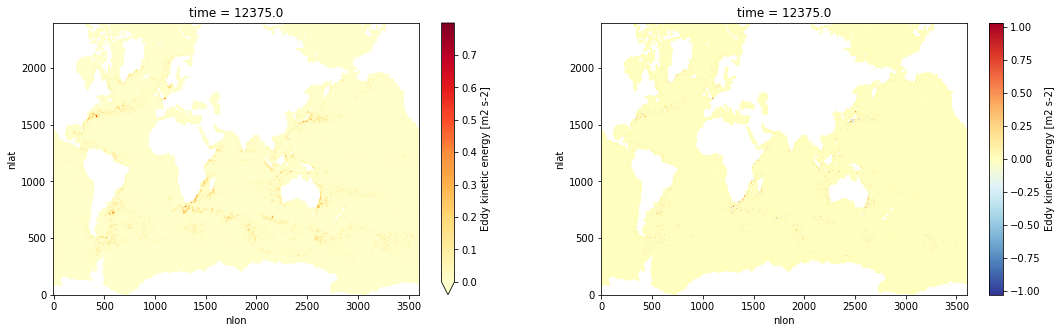

In [22]:
fig,axs = plt.subplots(1,2,figsize=(18,5))
ds_ff_g['EKE'].plot(ax=axs[0],cmap='YlOrRd',vmin=0)
ds_ff_t['EKE'].plot(ax=axs[1],cmap='RdYlBu_r')

In [23]:
EKEmin_g = np.min(ds_ff_g['EKE'])
EKEmin_t = np.min(ds_ff_t['EKE'])
print('min EKE; Gaussian: %g, Taper: %g' %(EKEmin_g,EKEmin_t))

min EKE; Gaussian: -0.000301333, Taper: -0.599906


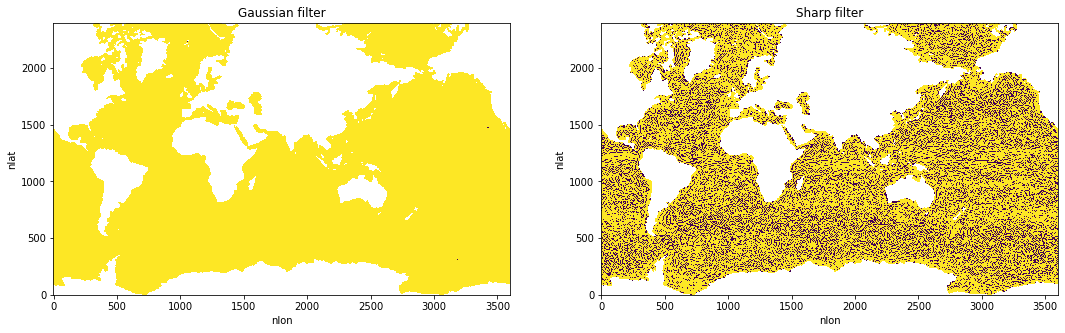

In [24]:
mask_g = xr.where(ds_ff_g['EKE']<0,-10000,ds_ff_g['EKE'])
mask_g = xr.where(mask_g>0,0,mask_g)

mask_t = xr.where(ds_ff_t['EKE']<0,-10000,ds_ff_t['EKE'])
mask_t = xr.where(mask_t>0,0,mask_t)

fig,axs = plt.subplots(1,2,figsize=(18,5))
mask_g.plot(ax=axs[0],add_colorbar=False)
mask_t.plot(ax=axs[1],add_colorbar=False)
axs[0].set(title='Gaussian filter')
axs[1].set(title='Sharp filter')
#plt.savefig('figures/EKE_negative_values.png',dpi=200,bbox_inches='tight',pad_inches=0)

### Plot EKE in Gulf Stream region

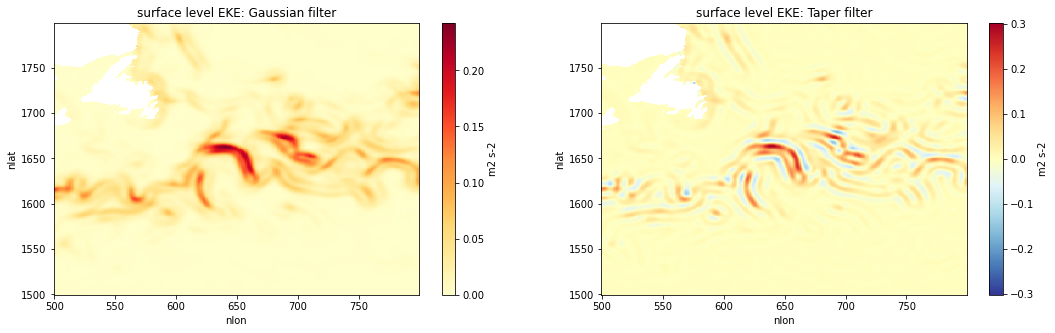

In [28]:
xslice = slice(500,800)
yslice = slice(1500,1800)

fig,axs = plt.subplots(1,2,figsize=(18,5))
        
ds_ff_g['EKE'].isel(nlon=xslice,nlat=yslice).plot(ax=axs[0],cmap='YlOrRd',
                                                    cbar_kwargs={"label": ds_ff_g['EKE'].units})

ds_ff_t['EKE'].isel(nlon=xslice,nlat=yslice).plot(ax=axs[1],cmap='RdYlBu_r',
                                                    cbar_kwargs={"label": ds_ff_t['EKE'].units})
axs[0].set(title='surface level EKE: Gaussian filter')
axs[1].set(title='surface level EKE: Taper filter')

#plt.savefig('figures/EKE_gulfstream.png',dpi=200,bbox_inches='tight',pad_inches=0)

## Plot Gulf Stream region on a lat/lon grid with cartopy

/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1598: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)


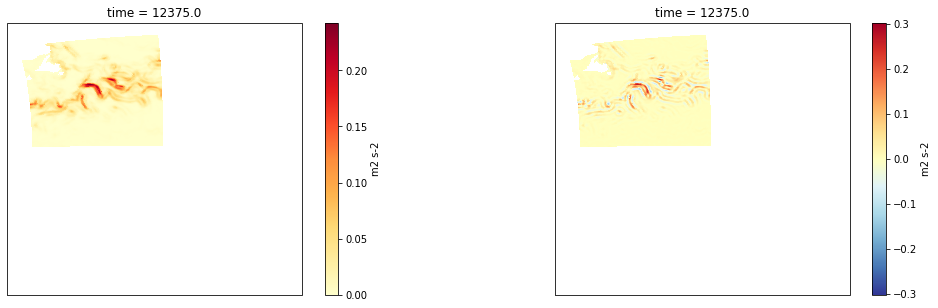

In [26]:
fig,axs = plt.subplots(1,2,figsize=(18,5),subplot_kw={'projection':ccrs.PlateCarree()})
        

ds_ff_g['EKE'].isel(nlon=xslice,nlat=yslice).plot(ax=axs[0],x='ULONG',y='ULAT',
                                                    cmap='YlOrRd',transform=ccrs.PlateCarree(),
                                                    cbar_kwargs={"label": ds_ff_g['EKE'].units})

ds_ff_t['EKE'].isel(nlon=xslice,nlat=yslice).plot(ax=axs[1],x='ULONG',y='ULAT',
                                                    cmap='RdYlBu_r',transform=ccrs.PlateCarree(),
                                                    cbar_kwargs={"label": ds_ff_t['EKE'].units})

#ax = plt.axes(facecolor='k', projection=ccrs.PlateCarree())
#ax.coastlines()

## Plot global EKE on a lat/lon grid with cartopy

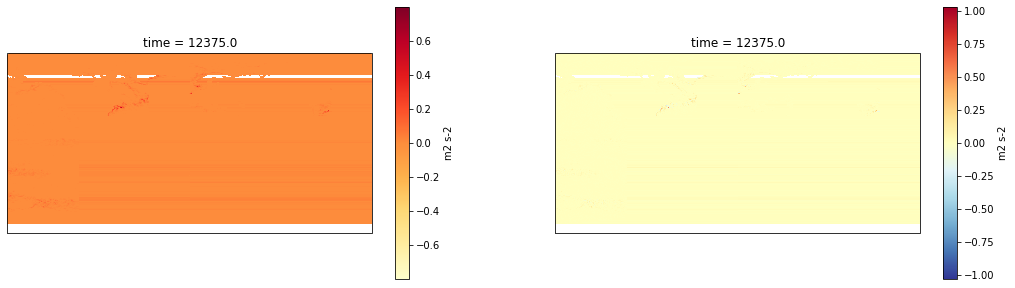

In [27]:
fig,axs = plt.subplots(1,2,figsize=(18,5),subplot_kw={'projection':ccrs.PlateCarree()})
        

ds_ff_g['EKE'].plot(ax=axs[0],x='ULONG',y='ULAT',
                    cmap='YlOrRd',transform=ccrs.PlateCarree(),
                    cbar_kwargs={"label": ds_ff_g['EKE'].units})

ds_ff_t['EKE'].plot(ax=axs[1],x='ULONG',y='ULAT',
                    cmap='RdYlBu_r',transform=ccrs.PlateCarree(),
                    cbar_kwargs={"label": ds_ff_t['EKE'].units})

#ax = plt.axes(facecolor='k', projection=ccrs.PlateCarree())
#ax.coastlines()